# 1. Define the Libraries and the Data

In [1]:
# Mounting Google Drive locally
# Import Google Drive Files and the Dataset
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Selection of Tensorflow version
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
# Import the Libraries that will be used
import os
import cv2
import glob
import keras
import random 
from random import randint
import numpy as np
from numpy import save
from numpy import expand_dims
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import ndimage, misc
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import itertools
import shutil
import warnings
!pip install -q keras
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# let us save the vgg16_model
import h5py

# load back a model
from keras.models import load_model

# let us import the necessary library to resize
from skimage.transform import resize

# library to convert 224 x 224 grayscale to rgb
from skimage.color import gray2rgb

In [4]:
# Load the Dataset

# 1000 x 128 x 128
x_128_train = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_train.npy'
np_x_128_train = np.load(x_128_train)

# 240 x 128 x 128
x_128_valid = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_valid.npy'
np_x_128_valid = np.load(x_128_valid)

# 300 x 128 x 128
x_128_test = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/x_128_test.npy'
np_x_128_test = np.load(x_128_test)

In [5]:
# Load Acrosome Labels

# for 1000 Samples
y_acrosome_train = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/y_acrosome_train.npy'
np_y_acrosome_train = np.load(y_acrosome_train)

# for 240 Samples
y_acrosome_valid = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/y_acrosome_valid.npy'
np_y_acrosome_valid = np.load(y_acrosome_valid)

# for 300 Samples
y_acrosome_test = '/content/drive/My Drive/AI/Male_Infertility_Assessment/MHSMA The Modified Human Sperm Morphology Analysis Dataset-20201116T105219Z-001/mhsma-dataset-master/mhsma/y_acrosome_test.npy'
np_y_acrosome_test = np.load(y_acrosome_test)


# TF - DCGAN

In [7]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [8]:
np_x_128_train.shape

(1000, 128, 128)

In [9]:
train_images = np_x_128_train.reshape(np_x_128_train.shape[0], 128, 128, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [10]:
train_images.shape

(1000, 128, 128, 1)

In [11]:
BUFFER_SIZE = 1000
BATCH_SIZE = 256

In [12]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# The Generator

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None, 32, 32, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

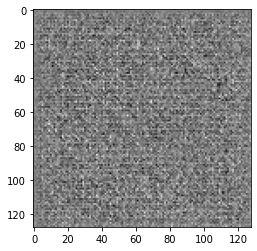

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 262144)            26214400  
_________________________________________________________________
batch_normalization (BatchNo (None, 262144)            1048576   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 262144)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0

# The Discriminator

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00075743]], shape=(1, 1), dtype=float32)


In [18]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)           

# Loss and Optimizers

In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
EPOCHS = 75
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [25]:
train_labels = np_y_acrosome_train

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-h0ktl0tx
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-h0ktl0tx
     |████████████████████████████████| 1.0MB 4.1MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.06f222c7765b0dfa83a1b2c37ba880ae73b892c25_-cp36-none-any.whl size=146698 sha256=ae99e8860f15f9ab2073308cb5b7b38a9711401bb4aeaa68e37022d2c321a854
  Stored in directory: /tmp/pip-ephem-wheel-cache-izdkspjh/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

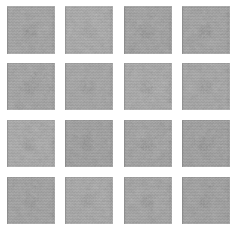

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# İlk Deneyişim

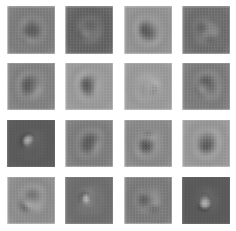

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

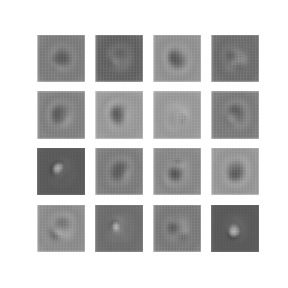

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

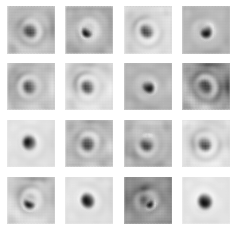

In [ ]:
train(train_dataset, EPOCHS+20)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

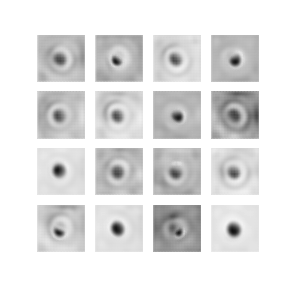

In [ ]:
display_image(EPOCHS+20)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=72heJ2lccJRB